In [6]:
pip install -U duckduckgo_search


  Using cached duckduckgo_search-6.2.12-py3-none-any.whl.metadata (25 kB)
Using cached duckduckgo_search-6.2.12-py3-none-any.whl (27 kB)
  Attempting uninstall: duckduckgo_search
    Found existing installation: duckduckgo-search 0.9.5
    Uninstalling duckduckgo-search-0.9.5:
      Successfully uninstalled duckduckgo-search-0.9.5
Note: you may need to restart the kernel to use updated packages.


In [4]:
!pip install fastcore

In [10]:
!pip install fastdownload

In [23]:
!pip install fastai.data.external

ERROR: Could not find a version that satisfies the requirement fastai.data.external (from versions: none)
ERROR: No matching distribution found for fastai.data.external


In [4]:
from duckduckgo_search import DDGS
from fastcore.all import *



def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(DDGS().images(term, max_results=max_images)).itemgot('image')

urls = search_images('bird photo', max_images = 1)
urls[0]

Searching for 'bird photo'


'https://images.pexels.com/photos/326900/pexels-photo-326900.jpeg?cs=srgb&dl=wood-flight-bird-326900.jpg&fm=jpg'

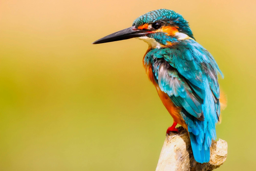

In [5]:
from fastdownload import download_url 
dest = 'Bird.jpg'
download_url(urls[0], dest, show_progress = true)

from fastai.vision.all import *

im = Image.open(dest)
im.to_thumb(256,256)

Searching for 'forest_photo'


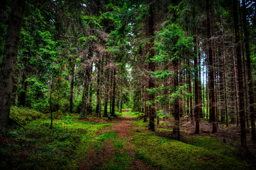

In [6]:
dest2 = 'forest.jpg'
download_url(search_images('forest_photo', max_images=1)[0], dest2, show_progress = true)

im2 = Image.open(dest2)
im2.to_thumb(256,256)

In [12]:
searches = 'Forest', 'Bird'
path = Path('Bird_or_Not')

from time import sleep

for item in searches:
    dest = (path/item)
    dest.mkdir(exist_ok = true, parents = true)

    download_images(dest, urls=search_images(f'{item} photo'))
    sleep(18)

    download_images(dest, urls=search_images(f'{item} sunny photo'))
    sleep(18)
    
    download_images(dest, urls=search_images(f'{item} shade photo'))
    sleep(18)

    resize_images(path/item, max_size=400, dest=path/item)

Searching for 'Forest photo'
Searching for 'Forest sunny photo'
Searching for 'Forest shade photo'
Searching for 'Bird photo'
Searching for 'Bird sunny photo'
Searching for 'Bird shade photo'


In [13]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

19

In [2]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu" 
device

'cuda'

To train a model, we'll need DataLoaders, which is an object that contains a training set (the images used to create a model) and a validation set (the images used to check the accuracy of a model -- not used during training). In fastai we can create that easily using a DataBlock, and view sample images from it:

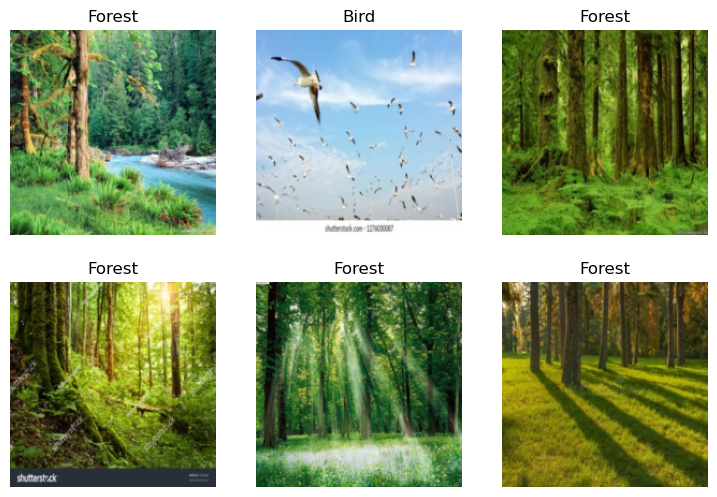

In [8]:
path = Path('Bird_or_Not')

dls = DataBlock(
     blocks = (ImageBlock, CategoryBlock),
     get_items = get_image_files,
     splitter = RandomSplitter(valid_pct = 0.2, seed = 42),
     get_y = parent_label,
     item_tfms = [Resize(192, method = 'squish')]
).dataloaders(path, bs = 32)

dls.show_batch(max_n = 6)

Here what each of the DataBlock parameters means:

blocks=(ImageBlock, CategoryBlock),

The inputs to our model are images, and the outputs are categories (in this case, "bird" or "forest").

get_items=get_image_files, 

To find all the inputs to our model, run the get_image_files function (which returns a list of all image files in a path).
  
splitter=RandomSplitter(valid_pct=0.2, seed=42),

Split the data into training and validation sets randomly, using 20% of the data for the validation set.

get_y=parent_label,

The labels (y values) is the name of the parent of each file (i.e. the name of the folder they're in, which will be bird or forest).

item_tfms=[Resize(192, Before training, resize each image to 192x192 pixels by "squishing" it (as opposed to cropping it).method='squish')]


In [16]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,0.798103,0.728189,0.333333,00:01


epoch,train_loss,valid_loss,error_rate,time
0,0.113718,0.028489,0.000000,00:01
1,0.068850,0.002196,0.000000,00:01
2,0.051840,0.001167,0.000000,00:01


Generally when I run this I see 100% accuracy on the validation set (although it might vary a bit from run to run).

"Fine-tuning" a model means that we're starting with a model someone else has trained using some other dataset (called the pretrained model), and adjusting the weights a little bit so that the model learns to recognise your particular dataset. In this case, the pretrained model was trained to recognise photos iIMAGENETet, and widely-used computer vision dataset with images covering 1000 categories
e.

In [ ]:
RUNNING THE MODEL


In [11]:
is_bird, _, probs = learn.predict(PILImage.create('Bird.jpg'))
print(f"This is a: {is_bird}")
print(f"Probability: {probs[0]: .4f}")

This is a: Bird
Probability:  1.0000


In [14]:
is_bird, _, probs = learn.predict(PILImage.create('forest.jpg'))
print(f"This is a: {is_bird}")
print(f"Probability of being a bird: {probs[0]: .4f}")
print(probs)

This is a: Forest
Probability of being a bird:  0.0060
tensor([0.0060, 0.9940])
